# Visualize spectra using embedding umap
This notebooks creates a 2D visualization of the case study spectrum set. By using Umap the multidiminsional embeddings are reduced to 2 dimensions. Annotations are added to make a interactive visualization possible

### Load ms2deepscore model

In [1]:
from ms2deepscore.models import load_model

filename_model = "../pytorch/gnps_corinna_mona_massbank/trained_models/both_mode_precursor_mz_ionmode_2000_2000_2000_layers_500_embedding_2024_08_09_11_13_23/ms2deepscore_model.pt"
model = load_model(filename_model)

c:\users\jonge094\pycharmprojects\ms2deepscore\ms2deepscore\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(f

In [2]:
from ms2deepscore import MS2DeepScore
ms2ds_model = MS2DeepScore(model)


### load spectra
The spectra are precprocessed in the notebook pre_processing_spectra.ipynb

In [5]:
from matchms.importing import load_from_mgf
spectra = list(load_from_mgf( "./cleaned_spectra_pos_neg_with_numbering.mgf"))

### Create embeddings
MS2Deepscore embeddings are a 500 dimensional representation of a spectrum. Similar embeddings should correspond to similar molecules.

In [6]:
ms2ds_embeddings = ms2ds_model.get_embedding_array(spectra)

2909it [00:35, 81.31it/s]


In [8]:
ms2ds_embeddings.shape

(2909, 500)

### Fit Umap
Umap is a method for reducing multidimensional data to 2 dimensions. This is done in a way that aims to keep distances between embeddings close to the thruth. However, since reducing from 500 dementions some distortions always take place. Reducing to 2 dimensions allows us to visualize the embeddings.

The code below tries to learn how to best transform 500 dimensions to 2 dimensions.

In [7]:
import umap

reducer = umap.UMAP(random_state=42,  # this or whatever your favorite number is
                    n_neighbors=50 ,  # key parameters How global or local the distribution 30, 50
                    min_dist=0.2 , # can the dots overlap if you use 5 they move out a bit. 0.1, 0.2
                    )
reducer.fit(ms2ds_embeddings)

C:\Users\jonge094\AppData\Local\miniconda3\envs\pytorch\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.2, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

### get 2d coordinates from embeddings
Here we use the fitted umap model to actually transform embeddings to a x and y coordinate

In [10]:
embedding_umap = reducer.transform(ms2ds_embeddings)

### Convert to pandas df
Use the query_spectrum_id from the spectra as index for the pandas dataframe

In [46]:
import pandas as pd
embedding_umap_df = pd.DataFrame(embedding_umap, 
                                 index = [spectrum.get("query_spectrum_nr") for spectrum in spectra],
                                columns = ["x", "y"])
indexes = embedding_umap_df.index
embedding_umap_df["query_spectrum_nr"] = indexes

In [47]:
embedding_umap_df

,x,y,query_spectrum_nr
pos_1,9.609632,3.039620,pos_1
pos_2,13.209635,11.478690,pos_2
pos_3,14.841822,4.592219,pos_3
pos_4,10.298793,6.759102,pos_4
pos_5,10.225416,6.791098,pos_5
...,...,...,...
neg_1311,13.359218,9.435593,neg_1311
neg_1312,13.223780,8.350902,neg_1312
neg_1313,11.782800,5.746759,neg_1313
neg_1314,13.610619,8.326217,neg_1314


### Visualize embeddings
We use plotly to visualize the embeddings of the spectra

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

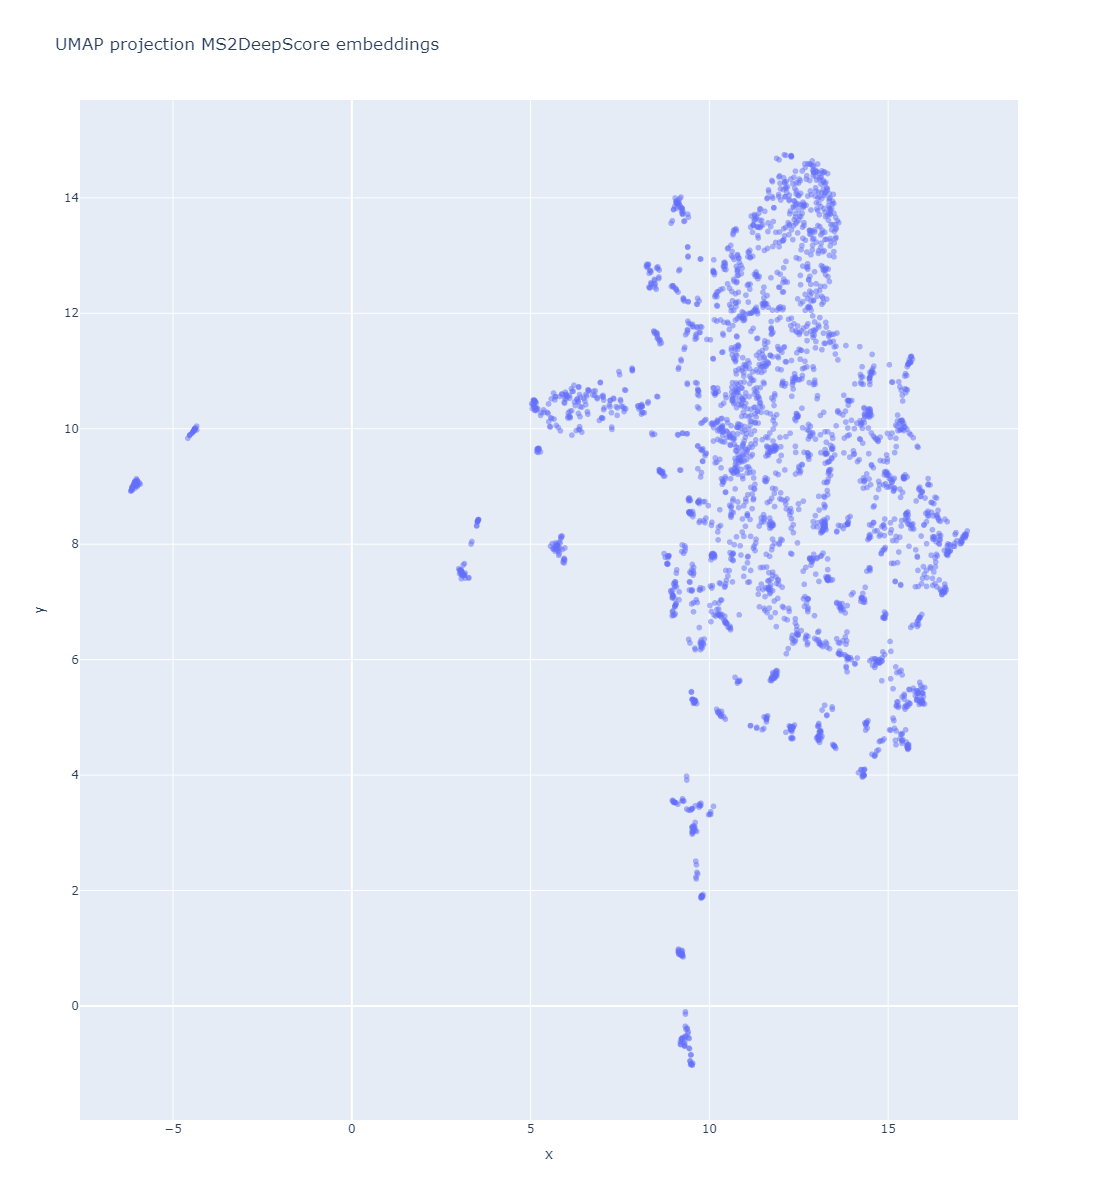

In [48]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(embedding_umap_df,
    x="x",
    y="y",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    width=1200,
    height=1200,
)

fig.show()

### Add annotations to visualization
Visualizing just the embeddings is not very informative. Below we add the ms2query annotations, but any information can be added in principle. 


In [97]:
ms2query_annotations = pd.read_csv("ms2query_and_NPC_annotation.csv")

### Merge annotations with umap table

In [98]:
merged_data = pd.merge(embedding_umap_df, ms2query_annotations, on="query_spectrum_nr", how= "outer")

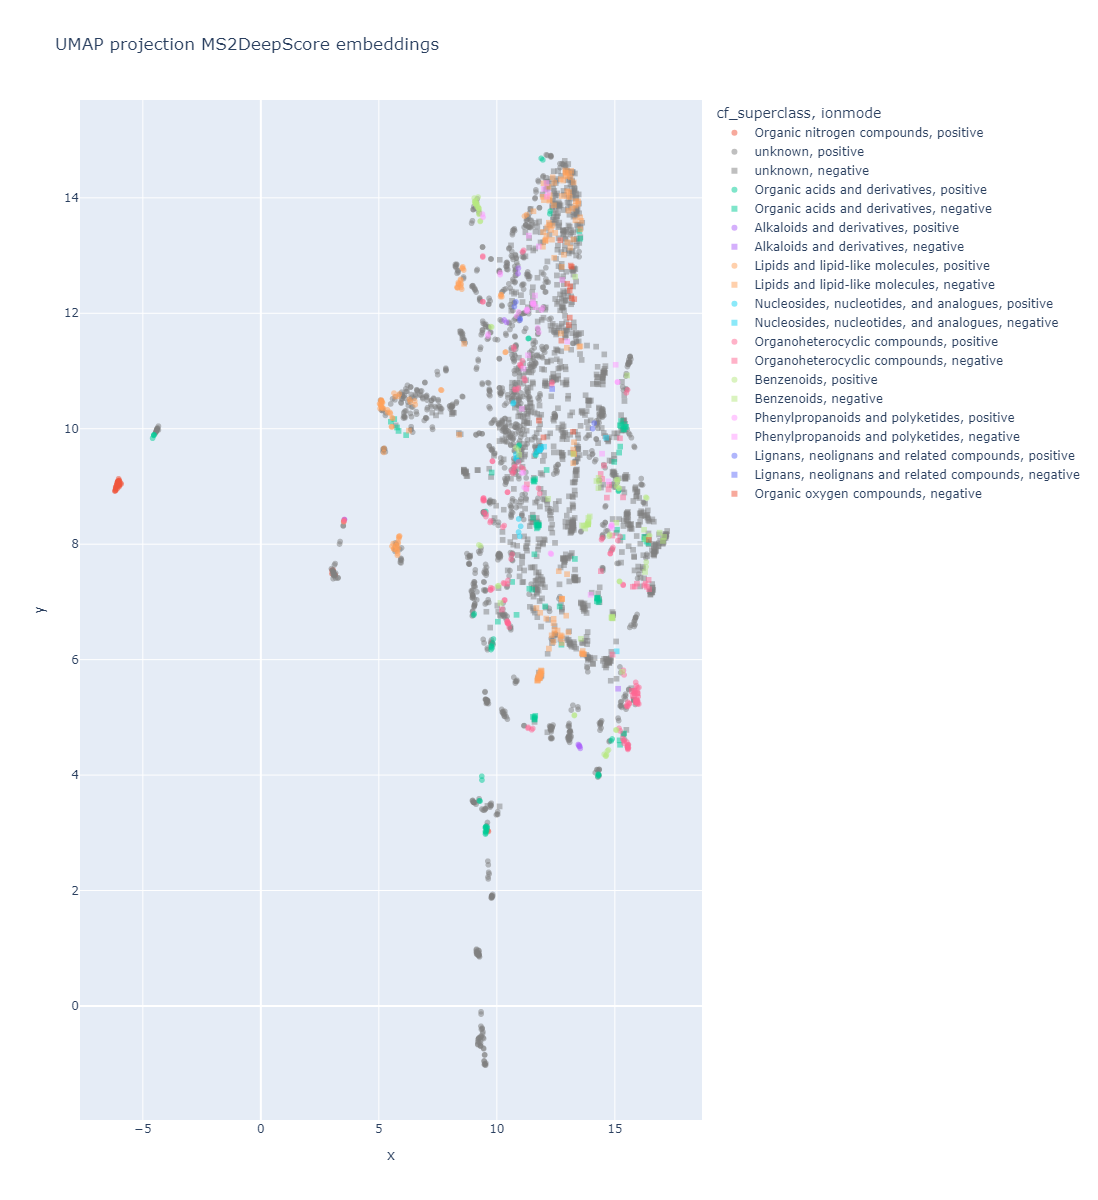

In [99]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(merged_data,
    x="x",
    y="y",
    color="cf_superclass",
    color_discrete_map={"unknown": 'grey'},

    # color_continuous_scale="viridis",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                # "fraction": True,
                "precursor_mz_difference": True,
               "ionmode": True,
               "ms2query_model_prediction": True,
               "smiles": True,
               "analog_compound_name": True,
               "rtinminutes": True},
    symbol="ionmode",
    width=1200,
    height=1200,
)

fig.show()


In [100]:
fig.write_html("embedding_visualization.html")

### Visualize molecular structures
By using molplotly molecular structures based on the ms2query annotation can be overlayed. 

In [101]:
merged_data = merged_data[merged_data["smiles"] != "unknown"]

In [102]:
# make number
merged_data.loc[:, "rtinminutes"] = merged_data["rtinminutes"].astype(float)

In [107]:
port = 8000

In [108]:
import pandas as pd
import plotly.express as px

import molplotly

# load a DataFrame with smiles
df_esol = pd.read_csv(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv')
df_esol['y'] = df_esol['ESOL predicted log solubility in mols per litre']
df_esol['x'] = df_esol['measured log solubility in mols per litre']

fig = px.scatter(merged_data,
    x="x",
    y="y",
    color="ionmode",
    symbol="cf_superclass",
    width=1200,
    height=800,
)

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=merged_data,
                              smiles_col='smiles',
                              color_col="ionmode",
                              caption_cols=['rtinminutes', "ionmode", "precursor_mz_query_spectrum", "analog_compound_name"],
                              show_coords=False,
                              symbol_col="cf_superclass"
                            )

port += 1 # If you want to recreate a plot the port has to not be used before (this makes it easy to not forget increasing the port)

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=port, height=1000)

C:\Users\jonge094\AppData\Roaming\Python\Python39\site-packages\dash\dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.

